# Importing libraries and reading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
from scipy import stats
from xgboost.sklearn import XGBClassifier

sns.set_palette(sns.color_palette("rocket_r"))

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "mohammedelhamamsy"
os.environ['KAGGLE_KEY'] = "0e194377b1319a21b5750c05367dc004"

In [3]:
!kaggle competitions download -c airbnb-recruiting-new-user-bookings

 98% 58.0M/59.1M [00:00<00:00, 41.7MB/s]
100% 59.1M/59.1M [00:00<00:00, 64.0MB/s]
  0% 0.00/478k [00:00<?, ?B/s]
100% 478k/478k [00:00<00:00, 53.5MB/s]
  0% 0.00/546 [00:00<?, ?B/s]
100% 546/546 [00:00<00:00, 543kB/s]
  0% 0.00/1.03M [00:00<?, ?B/s]
100% 1.03M/1.03M [00:00<00:00, 147MB/s]
  0% 0.00/2.46k [00:00<?, ?B/s]
100% 2.46k/2.46k [00:00<00:00, 2.12MB/s]
100% 4.07M/4.07M [00:00<00:00, 38.2MB/s]



In [4]:
train_users = pd.read_csv('train_users_2.csv.zip')
train_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


In [5]:
test_users = pd.read_csv('test_users.csv.zip')
test_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,cv0na2lf5a,2014-09-30,20140930235232,NaN,-unknown-,31.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE
62092,zp8xfonng8,2014-09-30,20140930235306,NaN,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-
62093,fa6260ziny,2014-09-30,20140930235408,NaN,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox
62094,87k0fy4ugm,2014-09-30,20140930235430,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari


> ## Session table

In [6]:
sessions = pd.read_csv('sessions.csv.zip')
sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [7]:
# Considering the mean time of a user interaction with website
sessions = sessions[['user_id','secs_elapsed']].groupby('user_id').mean().reset_index()

In [8]:
# Joining the train_users data with the time they took interacting with the website
train_users = pd.merge(train_users,sessions,left_on='id',right_on='user_id',how='left').drop('user_id',axis=1)
del sessions

In [9]:
train_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,secs_elapsed
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaN
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,NaN
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,NaN
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,NaN
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF,47168.770642
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,12147.358650
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,20175.411765
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF,4616.337838


# Preprocessing and validation

> ## General

In [10]:
np.sum(train_users.isna())

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
secs_elapsed               140820
dtype: int64

In [11]:
train_users.describe()

,timestamp_first_active,age,signup_flow,secs_elapsed
count,2.134510e+05,125461.000000,213451.000000,7.263100e+04
mean,2.013085e+13,49.668335,3.267387,3.266175e+04
std,9.253717e+09,155.666612,7.637707,6.039221e+04
min,2.009032e+13,1.000000,0.000000,0.000000e+00
25%,2.012123e+13,28.000000,0.000000,9.579359e+03
50%,2.013091e+13,34.000000,0.000000,1.817675e+04
75%,2.014031e+13,43.000000,0.000000,3.473961e+04
max,2.014063e+13,2014.000000,25.000000,1.703242e+06


> ## Missing Values

> > ### Age

In [12]:
# Force non numeric values in age to be missing
train_users['age'] = pd.to_numeric(train_users['age'], errors='coerce')

In [13]:
def age_correction(age):
  # Correct values
  if age>=18 and age<=120:
    return age
  # Values substituted with date of birth
  age = 2014 -age
  if age>=18 and age<=120:
    return age
  # Wrong Entries 
  return np.nan

# Correct the ages 
train_users['age'] = train_users['age'].map(age_correction)

In [14]:
# Having a look
train_users['age'].describe()

count    124551.000000
mean         37.452931
std          13.943422
min          18.000000
25%          28.000000
50%          34.000000
75%          43.000000
max         115.000000
Name: age, dtype: float64

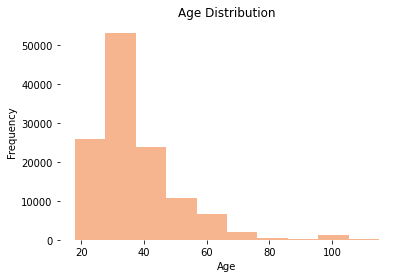

In [15]:
# Data is right skewed
from pylab import *
axes(frameon = 0)
rcParams['figure.figsize'] = 5, 5
_ = plt.hist(train_users['age'])
_ = plt.title('Age Distribution')
_ = plt.xlabel('Age')
_ = plt.ylabel('Frequency')
_ = plt.show()

In [16]:
# impute missing values with median 
train_users['age'] = train_users['age'].fillna(train_users['age'].median())

> > ### Secs elapsed

In [17]:
# Secs elapsed is around 70% empty
train_users.drop('secs_elapsed',axis=1,inplace=True)

> > ### First Affiliate Tracked

In [18]:
# Fill affiliate tracked with most occurring
most_freq_affiliate = stats.mode(train_users['first_affiliate_tracked'])[0][0]
train_users.drop('first_affiliate_tracked',axis=1,inplace=True)
test_users.drop('first_affiliate_tracked',axis=1,inplace=True)

# Feature Engineering

> ## Dates

In [19]:
# Date of account creation to date time
train_users['date_account_created'] = pd.to_datetime(train_users['date_account_created'], format='%Y-%m-%d')
test_users['date_account_created'] = pd.to_datetime(test_users['date_account_created'], format='%Y-%m-%d')

In [20]:
# Date of first active
train_users['timestamp_first_active'] = pd.to_datetime(train_users['timestamp_first_active'], format='%Y%m%d%H%M%S') 
test_users['timestamp_first_active'] = pd.to_datetime(test_users['timestamp_first_active'], format='%Y%m%d%H%M%S') 

In [21]:
# days elapsed between creation and first active
train_users['Days_Bet_Creation_FirstActive'] = train_users['date_account_created'] - train_users['timestamp_first_active'] 
train_users['Days_Bet_Creation_FirstActive'] = train_users['Days_Bet_Creation_FirstActive'].astype('timedelta64[D]') 

test_users['Days_Bet_Creation_FirstActive'] = test_users['date_account_created'] - test_users['timestamp_first_active'] 
test_users['Days_Bet_Creation_FirstActive'] = test_users['Days_Bet_Creation_FirstActive'].astype('timedelta64[D]') 

In [22]:
# Year of account creation
train_users['account_creation_year'] = pd.DatetimeIndex(train_users['date_account_created']).year
test_users['account_creation_year'] = pd.DatetimeIndex(test_users['date_account_created']).year

# Month of account creation
train_users['account_creation_month'] = pd.DatetimeIndex(train_users['date_account_created']).month
test_users['account_creation_month'] = pd.DatetimeIndex(test_users['date_account_created']).month

# Month of account creation sine & cosine components
# This is to account for the fact the Jan(1) resembles Dec(12) than for instance june(6)
train_users['account_creation_month_sin'] = np.sin(2 * np.pi * (train_users['account_creation_month']-1) / 12) # Sine Component
train_users['account_creation_month_cos'] = np.cos(2 * np.pi * (train_users['account_creation_month']-1) / 12) # Cosine Component

test_users['account_creation_month_sin'] = np.sin(2 * np.pi * (test_users['account_creation_month']-1) / 12) # Sine Component
test_users['account_creation_month_cos'] = np.cos(2 * np.pi * (test_users['account_creation_month']-1) / 12) # Cosine Component

# EDA

> ## Country Dest

In [23]:
# Function to return whether or not the user has booked
def booked(val):
  return str((val != 'NDF')+0)

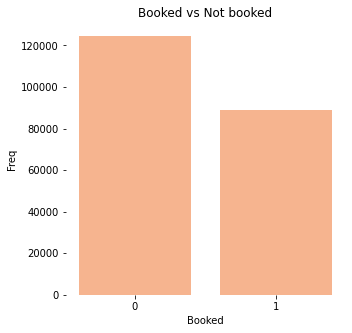

In [25]:
booked_dist = train_users['country_destination'].map(booked).value_counts()
axes(frameon = 0)
rcParams['figure.figsize'] = 5, 5

_ = plt.bar(booked_dist.index,booked_dist.values)
_ = plt.title('Booked vs Not booked')
_ = plt.xlabel('Booked')
_ = plt.ylabel('Freq')

In [73]:
train_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,Days_Bet_Creation_FirstActive,account_creation_year,account_creation_month,account_creation_month_sin,account_creation_month_cos
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,34.0,facebook,0,en,direct,direct,Web,Mac Desktop,Chrome,NDF,465.0,2010,6,0.500000,-0.866025
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,Web,Mac Desktop,Chrome,NDF,731.0,2011,5,0.866025,-0.500000
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,NaT,FEMALE,56.0,basic,3,en,direct,direct,Web,Windows Desktop,IE,US,475.0,2010,9,-0.866025,-0.500000
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,Web,Mac Desktop,Firefox,other,764.0,2011,12,-0.500000,0.866025
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,NaT,-unknown-,41.0,basic,0,en,direct,direct,Web,Mac Desktop,Chrome,US,279.0,2010,9,-0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaT,MALE,32.0,basic,0,en,sem-brand,google,Web,Mac Desktop,Safari,NDF,-1.0,2014,6,0.500000,-0.866025
213447,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaT,-unknown-,34.0,basic,0,en,direct,direct,Web,Windows Desktop,Chrome,NDF,-1.0,2014,6,0.500000,-0.866025
213448,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaT,-unknown-,32.0,basic,0,en,direct,direct,Web,Mac Desktop,Firefox,NDF,-1.0,2014,6,0.500000,-0.866025
213449,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaT,-unknown-,34.0,basic,25,en,other,other,iOS,iPhone,Mobile Safari,NDF,-1.0,2014,6,0.500000,-0.866025


In [26]:
# Probability of booking
booked_dist.values/np.sum(booked_dist.values)

array([0.58347349, 0.41652651])

> ## Average days for first booking

In [29]:
# date of first booking as time
train_users['date_first_booking'] = pd.to_datetime(train_users['date_first_booking'], format='%Y-%m-%d')

# Number of wrong observations with booking date before account creation
day_diff_cre_book = (train_users['date_first_booking']-train_users['date_account_created']).astype('timedelta64[D]')
np.sum(day_diff_cre_book < 0)

0

In [30]:
# set the booking date to null in these obs
train_users.loc[(day_diff_cre_book < 0) , 'date_first_booking'] = np.nan
day_diff_cre_book = (train_users['date_first_booking']-train_users['date_account_created']).astype('timedelta64[D]')

np.sum(day_diff_cre_book < 0)

0

In [31]:
# Average days for the whole base between account creation and first booking
np.mean(day_diff_cre_book[day_diff_cre_book.notna()])

44.41913162839366

In [32]:
day_diff_cre_book = pd.DataFrame(day_diff_cre_book)
day_diff_cre_book.columns = ['Average_Days_Till_Booking']
day_diff_cre_book['Country_Dest'] = train_users['country_destination'] 

In [33]:
day_diff_cre_book[day_diff_cre_book['Average_Days_Till_Booking'].notna()].groupby('Country_Dest').mean()

,Average_Days_Till_Booking
Country_Dest,
AU,46.269517
CA,45.794530
DE,39.822642
ES,37.350823
FR,37.585905
GB,39.499785
IT,36.810448
NL,42.101050
PT,44.488479


In [34]:
day_diff_cre_book['gender'] = train_users['gender']
day_diff_cre_book[(day_diff_cre_book['gender'] == 'MALE') | (day_diff_cre_book['gender'] == 'FEMALE')][day_diff_cre_book['Average_Days_Till_Booking'].notna()][['gender','Average_Days_Till_Booking']].groupby('gender').mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Average_Days_Till_Booking
gender,
FEMALE,52.663675
MALE,48.154890


In [35]:
day_diff_cre_book['signup_flow'] = train_users['signup_flow']
day_diff_cre_book[day_diff_cre_book['Average_Days_Till_Booking'].notna()][['signup_flow','Average_Days_Till_Booking']].groupby('signup_flow').mean()

,Average_Days_Till_Booking
signup_flow,
0,44.149338
1,158.815476
2,39.456474
3,18.898432
5,111.500000
6,41.792683
8,47.181818
10,1.000000
12,64.461312


In [105]:
train_users['signup_flow'].value_counts()

0     164739
25     14659
12      9329
3       8822
2       6881
24      4328
23      2835
1       1047
6        301
8        240
21       196
5         36
20        14
16        11
15        10
10         2
4          1
Name: signup_flow, dtype: int64

> ## Convergence rates

In [48]:
# convergence rates across months
month_year_convergence = train_users[['account_creation_year','account_creation_month','country_destination']]
month_year_convergence['country_destination'] = month_year_convergence['country_destination'].map(booked).map(int) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
# total created, and total booked per month-year
month_year_convergence = month_year_convergence.groupby(['account_creation_year','account_creation_month']).agg(
    created=pd.NamedAgg(column="country_destination", aggfunc="count"),
    booked=pd.NamedAgg(column="country_destination", aggfunc="sum"))

In [44]:
# calculating the convergence rates
month_year_convergence['convergence'] = month_year_convergence['booked'] / month_year_convergence['created']

In [46]:
month_year_convergence

created  booked  convergence
account_creation_year account_creation_month                              
2010                  1                            61      32     0.524590
                      2                           102      55     0.539216
                      3                           163     106     0.650307
                      4                           157      91     0.579618
                      5                           227     128     0.563877
                      6                           222     109     0.490991
                      7                           307     180     0.586319
                      8                           312     180     0.576923
                      9                           371     218     0.587601
                      10                          309     191     0.618123
                      11                          286     164     0.573427
                      12                          271     149     0.549815
2011                  1                           316     189     0.598101
                      2                           362     215     0.593923
                      3                           491     326     0.663951
                      4                           577     372     0.644714
                      5                           744     468     0.629032
                      6                           822     506     0.615572
                      7                           993     644     0.648540
                      8                          1454     775     0.533012
                      9                          1864     859     0.460837
                      10                         1477     740     0.501016
                      11                         1386     688     0.496392
                      12                         1289     651     0.505043
2012                  1                          1589     797     0.501573
                      2                          1789     905     0.505869
                      3                          2192    1182     0.539234
                      4                          2589    1371     0.529548
                      5                          3325    1695     0.509774
                      6                          3867    1619     0.418671
                      7                          4582    1866     0.407246
                      8                          4476    1953     0.436327
                      9                          4035    1810     0.448575
                      10                         3828    1641     0.428683
                      11                         3706    1530     0.412844
                      12                         3484    1380     0.396096
2013                  1                          4418    1859     0.420779
                      2                          4362    1961     0.449564
                      3                          5421    2434     0.448995
                      4                          5855    2531     0.432280
                      5                          6721    2910     0.432971
                      6                          6765    2879     0.425573
                      7                          7950    3340     0.420126
                      8                          8369    3474     0.415103
                      9                          9125    3365     0.368767
                      10                         7862    3153     0.401043
                      11                         7751    2906     0.374919
                      12                         8361    3072     0.367420
2014                  1                         11111    4142     0.372784
                      2                          9967    3888     0.390087
                      3                         12058    4622     0.383314
                      4                         12689    4901     0.386

In [47]:
train_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,Days_Bet_Creation_FirstActive,account_creation_year,account_creation_month,account_creation_month_sin,account_creation_month_cos
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,34.0,facebook,0,en,direct,direct,Web,Mac Desktop,Chrome,NDF,465.0,2010,6,0.500000,-0.866025
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,Web,Mac Desktop,Chrome,NDF,731.0,2011,5,0.866025,-0.500000
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,NaT,FEMALE,56.0,basic,3,en,direct,direct,Web,Windows Desktop,IE,US,475.0,2010,9,-0.866025,-0.500000
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,Web,Mac Desktop,Firefox,other,764.0,2011,12,-0.500000,0.866025
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,NaT,-unknown-,41.0,basic,0,en,direct,direct,Web,Mac Desktop,Chrome,US,279.0,2010,9,-0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaT,MALE,32.0,basic,0,en,sem-brand,google,Web,Mac Desktop,Safari,NDF,-1.0,2014,6,0.500000,-0.866025
213447,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaT,-unknown-,34.0,basic,0,en,direct,direct,Web,Windows Desktop,Chrome,NDF,-1.0,2014,6,0.500000,-0.866025
213448,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaT,-unknown-,32.0,basic,0,en,direct,direct,Web,Mac Desktop,Firefox,NDF,-1.0,2014,6,0.500000,-0.866025
213449,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaT,-unknown-,34.0,basic,25,en,other,other,iOS,iPhone,Mobile Safari,NDF,-1.0,2014,6,0.500000,-0.866025


> ## Probability of booikng within timeframe

In [57]:
day_diff_total = day_diff_cre_book
day_diff_cre_book = day_diff_cre_book[day_diff_cre_book['Average_Days_Till_Booking'].notna()]

In [66]:
day_diff_cre_book[day_diff_cre_book['Average_Days_Till_Booking']<7 & ((day_diff_cre_book['gender'] == 'MALE') | (day_diff_cre_book['gender'] == 'FEMALE'))]

,Average_Days_Till_Booking,Country_Dest,gender,signup_flow
19,0.0,FR,FEMALE,0
36,0.0,US,FEMALE,0
58,0.0,US,MALE,0
84,0.0,US,FEMALE,0
107,0.0,FR,FEMALE,3
...,...,...,...,...
213279,0.0,other,FEMALE,0
213285,0.0,US,MALE,0
213313,0.0,other,MALE,0
213315,0.0,US,FEMALE,0


In [71]:
day_diff_cre_book[day_diff_cre_book['Average_Days_Till_Booking']<7].groupby('Country_Dest').agg(
    created=pd.NamedAgg(column="Country_Dest", aggfunc="count"))

,created
Country_Dest,
AU,290
CA,879
DE,620
ES,1324
FR,2849
GB,1349
IT,1651
NL,459
PT,132


In [72]:
day_diff_cre_book.groupby('Country_Dest').agg(
    created=pd.NamedAgg(column="Country_Dest", aggfunc="count"))

,created
Country_Dest,
AU,538
CA,1426
DE,1060
ES,2249
FR,5023
GB,2323
IT,2833
NL,762
PT,217


In [68]:
p_week = 53709/88879
p_week

0.24082179142429597

> ## Days between first active and creation

In [170]:
# Almost all the data have a one day difference between first active and account creation day
quants = [x/160 for x in range(150,160)]
train_users['Days_Bet_Creation_FirstActive'].quantile(quants)

0.93750   -1.0
0.94375   -1.0
0.95000   -1.0
0.95625   -1.0
0.96250   -1.0
0.96875   -1.0
0.97500   -1.0
0.98125   -1.0
0.98750   -1.0
0.99375   -1.0
Name: Days_Bet_Creation_FirstActive, dtype: float64

In [171]:
# we can drop it
train_users.drop('Days_Bet_Creation_FirstActive',axis=1,inplace=True)

# dropping date_first_booking to avoid data leakage
train_users.drop(['date_account_created','timestamp_first_active','date_first_booking'],axis=1,inplace=True)
test_users.drop(['date_account_created','timestamp_first_active','date_first_booking'],axis=1,inplace=True)

# Transformations

> ## Encoding Categorical

In [74]:
train_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,country_destination,Days_Bet_Creation_FirstActive,account_creation_year,account_creation_month,account_creation_month_sin,account_creation_month_cos
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,34.0,facebook,0,en,direct,direct,Web,Mac Desktop,Chrome,NDF,465.0,2010,6,0.500000,-0.866025
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,Web,Mac Desktop,Chrome,NDF,731.0,2011,5,0.866025,-0.500000
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,NaT,FEMALE,56.0,basic,3,en,direct,direct,Web,Windows Desktop,IE,US,475.0,2010,9,-0.866025,-0.500000
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,Web,Mac Desktop,Firefox,other,764.0,2011,12,-0.500000,0.866025
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,NaT,-unknown-,41.0,basic,0,en,direct,direct,Web,Mac Desktop,Chrome,US,279.0,2010,9,-0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,2014-06-30 23:56:36,NaT,MALE,32.0,basic,0,en,sem-brand,google,Web,Mac Desktop,Safari,NDF,-1.0,2014,6,0.500000,-0.866025
213447,mhewnxesx9,2014-06-30,2014-06-30 23:57:19,NaT,-unknown-,34.0,basic,0,en,direct,direct,Web,Windows Desktop,Chrome,NDF,-1.0,2014,6,0.500000,-0.866025
213448,6o3arsjbb4,2014-06-30,2014-06-30 23:57:54,NaT,-unknown-,32.0,basic,0,en,direct,direct,Web,Mac Desktop,Firefox,NDF,-1.0,2014,6,0.500000,-0.866025
213449,jh95kwisub,2014-06-30,2014-06-30 23:58:22,NaT,-unknown-,34.0,basic,25,en,other,other,iOS,iPhone,Mobile Safari,NDF,-1.0,2014,6,0.500000,-0.866025


In [75]:
cat_cols = ['gender','signup_method','signup_flow','language','affiliate_channel','affiliate_provider','signup_app','first_device_type','first_browser']

In [76]:
x_train = train_users.drop('country_destination',axis=1)
y_train = train_users[['country_destination']]



from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Categorcal features OHencoded
enc = OneHotEncoder(handle_unknown='ignore').fit(x_train[cat_cols])
train_cat = enc.transform(x_train[cat_cols])

test_features_cat = enc.transform(test_users[cat_cols])

# label encoding labels
le = LabelEncoder().fit(y_train['country_destination'])
y_train = pd.Series(le.transform(y_train['country_destination'].to_numpy()))

In [77]:
y_train.value_counts()

7     124543
10     62376
11     10094
4       5023
6       2835
5       2324
3       2249
1       1428
2       1061
8        762
0        539
9        217
dtype: int64

In [78]:
train_cat

<213451x140 sparse matrix of type '<class 'numpy.float64'>'
	with 1921059 stored elements in Compressed Sparse Row format>

> ## Train Test Split

In [79]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
# partial_x_train, partial_x_test , partial_y_train, partial_y_test = train_test_split(
#     x_train, y_train, test_size=0.2, random_state=42)

In [80]:
for train_index,test_index in sss.split(x_train, y_train):
  pass

> ## Scaling Numerical

In [81]:
minmax_num_cols = ['account_creation_year',	'account_creation_month', 'age']

In [82]:
x_train[minmax_num_cols]

,account_creation_year,account_creation_month,age
0,2010,6,34.0
1,2011,5,38.0
2,2010,9,56.0
3,2011,12,42.0
4,2010,9,41.0
...,...,...,...
213446,2014,6,32.0
213447,2014,6,34.0
213448,2014,6,32.0
213449,2014,6,34.0


In [83]:
# Min max scaling numerical variables
from sklearn.preprocessing import MinMaxScaler

scaler    = MinMaxScaler().fit(x_train[minmax_num_cols].loc[train_index,:])
train_num = scaler.transform(x_train[minmax_num_cols].loc[train_index,:])
test_num  = scaler.transform(x_train[minmax_num_cols].loc[test_index,:])

test_features_num = scaler.transform(test_users[minmax_num_cols])

> ## Joining Data

In [84]:
print(train_num.shape)
print(train_cat.shape)

(170760, 3)
(213451, 140)


In [85]:
x_train = np.concatenate((train_num,train_cat.toarray()[train_index]),axis = 1)
x_test = np.concatenate((test_num,train_cat.toarray()[test_index]),axis = 1)

test_features = np.concatenate((test_features_num,test_features_cat.toarray()),axis = 1)

In [86]:
print(x_train.shape)
print(x_test.shape)
print(test_features.shape)

(170760, 143)
(42691, 143)
(62096, 143)


# Model

> ## XGboost

In [87]:
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
xgb.fit(x_train, y_train[train_index])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=25, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.5, verbosity=1)

In [88]:
y_pred = xgb.predict_proba(x_test)
y_pred

array([[0.00466784, 0.00528655, 0.00405451, ..., 0.00200335, 0.52019006,
        0.06550819],
       [0.00373955, 0.00735457, 0.00549028, ..., 0.00237108, 0.32342803,
        0.0559575 ],
       [0.00576659, 0.00953758, 0.00725727, ..., 0.00262616, 0.43130335,
        0.05784834],
       ...,
       [0.00256717, 0.00456352, 0.00300288, ..., 0.00203614, 0.23154859,
        0.04528139],
       [0.00195703, 0.00585432, 0.00331892, ..., 0.00178603, 0.1413622 ,
        0.0372379 ],
       [0.00458802, 0.00501227, 0.00752323, ..., 0.00170295, 0.27702457,
        0.05421592]], dtype=float32)

In [89]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train[test_index],np.argmax(y_pred,axis=1))

0.6304139045700499

In [108]:
ranked_feature_ind = xgb.feature_importances_.argsort()[-10:][::-1]

In [98]:
feature_names=['account_creation_year',	'account_creation_month',	'age']
for col in cat_cols:
  for val in train_users[col].unique():
    feature_names.append(f'{col}_{val}')

feature_names = np.array(feature_names)

In [109]:
feature_names[ranked_feature_ind]

array(['signup_method_basic', 'gender_-unknown-', 'signup_flow_3',
       'signup_app_iOS', 'affiliate_channel_seo', 'gender_MALE', 'age',
       'signup_flow_0', 'signup_flow_23', 'signup_method_facebook'],
      dtype='<U38')

> ## test data

In [195]:
test_pred = xgb.predict_proba(test_features)
test_pred

array([[0.00258702, 0.00351404, 0.00324742, ..., 0.00192486, 0.18593088,
        0.03911161],
       [0.00373253, 0.01341279, 0.00653063, ..., 0.00212694, 0.3633563 ,
        0.04925071],
       [0.00315566, 0.02293273, 0.01323743, ..., 0.00230669, 0.36503765,
        0.07123142],
       ...,
       [0.0035911 , 0.00992094, 0.02225747, ..., 0.00241857, 0.33297372,
        0.05731001],
       [0.00535701, 0.00674611, 0.00614046, ..., 0.00273074, 0.34250373,
        0.05735009],
       [0.00411604, 0.00942119, 0.0074675 , ..., 0.00364299, 0.35984594,
        0.05294028]], dtype=float32)

In [198]:
test_users

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,signup_app,first_device_type,first_browser,Days_Bet_Creation_FirstActive,account_creation_year,account_creation_month,account_creation_month_sin,account_creation_month_cos
0,5uwns89zht,FEMALE,35.0,facebook,0,en,direct,direct,Moweb,iPhone,Mobile Safari,-1.0,2014,7,1.224647e-16,-1.0
1,jtl0dijy2j,-unknown-,NaN,basic,0,en,direct,direct,Moweb,iPhone,Mobile Safari,-1.0,2014,7,1.224647e-16,-1.0
2,xx0ulgorjt,-unknown-,NaN,basic,0,en,direct,direct,Web,Windows Desktop,Chrome,-1.0,2014,7,1.224647e-16,-1.0
3,6c6puo6ix0,-unknown-,NaN,basic,0,en,direct,direct,Web,Windows Desktop,IE,-1.0,2014,7,1.224647e-16,-1.0
4,czqhjk3yfe,-unknown-,NaN,basic,0,en,direct,direct,Web,Mac Desktop,Safari,-1.0,2014,7,1.224647e-16,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,cv0na2lf5a,-unknown-,31.0,basic,0,en,direct,direct,Web,Windows Desktop,IE,-1.0,2014,9,-8.660254e-01,-0.5
62092,zp8xfonng8,-unknown-,NaN,basic,23,ko,direct,direct,Android,Android Phone,-unknown-,-1.0,2014,9,-8.660254e-01,-0.5
62093,fa6260ziny,-unknown-,NaN,basic,0,de,direct,direct,Web,Windows Desktop,Firefox,-1.0,2014,9,-8.660254e-01,-0.5
62094,87k0fy4ugm,-unknown-,NaN,basic,0,en,sem-brand,google,Web,Mac Desktop,Safari,-1.0,2014,9,-8.660254e-01,-0.5


In [199]:
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(test_users['id'])):
    idx = test_users['id'][i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(test_pred[i])[::-1])[:5].tolist()

In [200]:
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
...,...,...
310475,9uqfg8txu3,NDF
310476,9uqfg8txu3,US
310477,9uqfg8txu3,other
310478,9uqfg8txu3,FR


In [201]:
sub.to_csv('sub.csv',index=False)

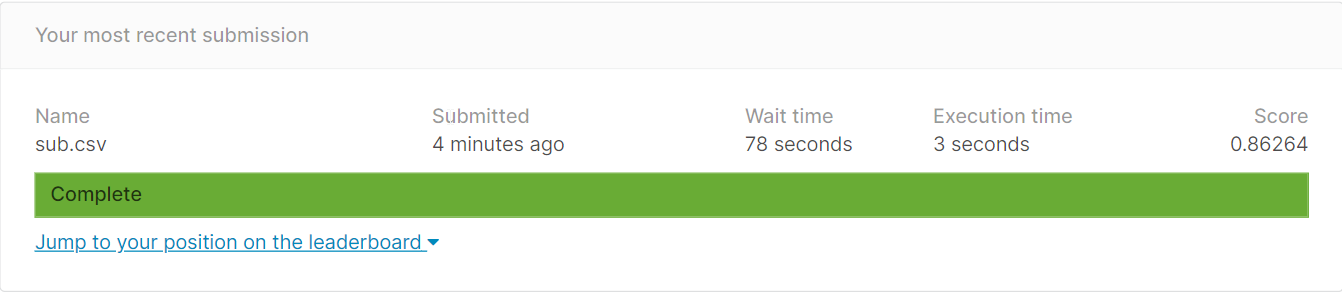